In [ ]:
#code: utf-8
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as albu

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, mean_squared_error

#from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as pat

In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'
CUR_PATH = '/content/gdrive/My Drive/Colab Notebooks/Othello_AI'
if ROOT_PATH not in sys.path:
  sys.path.append(ROOT_PATH)
if CUR_PATH not in sys.path:
  sys.path.append(CUR_PATH)

#for load params of trained model
SL_MODEL_NAME = "conv4_bn_mini"
SL_No = 40
SL_PARAM_NAME = f"SLpn_{SL_MODEL_NAME}_{SL_No}"
SL_PARAM_PATH = os.path.join(CUR_PATH, "SLpn_params", f"{SL_PARAM_NAME}.pth")

#for save params of policy model
RL_MODEL_NAME = "dqn_conv4"
RL_No = 61 #51
RL_PARAM_NAME = f"RLpn_{RL_MODEL_NAME}_{RL_No}"
RL_PARAM_PATH = os.path.join(CUR_PATH, "RLpn_params", f"{RL_PARAM_NAME}.pth")

#for making battle data
BATTLE = False
BATTLE_EPOCH = 50000 #1.5 h with (max vs max) 2.5h with (prob vs prob)
BATTLE_No = 6
BATTLE_DATA_PATH = os.path.join(CUR_PATH, "value_data", f"battle_data_{BATTLE_No}.csv")

#for value model training
TRAIN = True
BATCH_SIZE = 256
TRAIN_EPOCH = 20 # 10 s / epoch = 100000 data
lr = 0.0001
VALUE_No = 6
No_list = [6] # for loading data
VALUE_PARAM_PATH = os.path.join(CUR_PATH, "value_data", f"value_params_{VALUE_No}.pth")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#battle data

- 0: 50000 battles: random vs random -> RLpn.max vs RLpn.max and dropped duplicated
- 1: same battle as 0 and not drop duplicated seed=2021
- 2: same as 1 exepted of seed=42
- 3: 50000 battles: random vs random -> RLpn.prob vs RLpn.prob seed=2021
- 6: using RLpn 61

#value model

- 0: 50 epoch but plateau in 10 epoch: trained with data 0
- 1: 20 epoch: trained with data 1
- 2: 20 epoch: trained with data 1+2
- 3: 20 eopch: trained with data 3
- 6: 20 epoch: trained with data 6

In [ ]:
import gym
import tools
env = gym.make("othello-v0")

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 2021
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
white, black = 1, 2

#making SL model and RL model

In [ ]:
class Conv4_bn_mini(nn.Module):
  def __init__(self):
    super(Conv4_bn_mini, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(64*8*8, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

#making select action

In [ ]:
class SelectAction(object):
    def __init__(self, model):
        self.model = model
        self.model.eval()


    def random(self):
        return torch.tensor([-1], device = device, dtype = torch.long)


    def prob(self, state, posts):
        with torch.no_grad():
            state = state.reshape(-1, 3, 8, 8)
            pred = self.model(state)
            if len(posts) > 0: #prob in capable to place
                pred = torch.gather(pred, 1, torch.tensor([posts], device=device, dtype=torch.long))
                pred = nn.Softmax(dim=1)(pred)
                idx = torch.multinomial(pred, 1).item()
                return torch.tensor([posts[idx]], device=device, dtype=torch.long)
            else: #skip turn
                return pred.max(1)[1].reshape(-1, 1)
    

    def max(self, state, posts):
        with torch.no_grad():
            state = state.reshape(-1, 3, 8, 8)
            pred = self.model(state)
            if len(posts) > 0: #determine : max in pred
                pred = torch.gather(pred, 1, torch.tensor([posts], device=device, dtype=torch.long))
                return pred.max(1)[1].reshape(-1, 1)
            else: #skip turn
                return pred.max(1)[1].reshape(-1, 1)

#making transform data function

In [ ]:
def transform_state(state, player):
    state = state.astype('float32')
    white_st = np.where(state == 3 - player, 1, 0)
    black_st = np.where(state == player, 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(3, 8, 8)
    #state = torch.tensor(state).float()
    #state = state.to(device)
    return state

#making memory class

In [ ]:
class Memory(object):
    def __init__(self, capacity):
        self.memory = [[0] for _ in range(capacity)]
        self.idx = 0

    
    def push(self, data):
        self.memory[self.idx] = data
        self.idx += 1
    

    def __call__(self):
        df = pd.DataFrame(self.memory)
        return df

#making a battle

In [ ]:
SLpn = Conv4_bn_mini().to(device)
SLpn.load_state_dict(torch.load(SL_PARAM_PATH, map_location=device))
SLpn.eval()
RLpn = Conv4_bn_mini().to(device)
RLpn.load_state_dict(torch.load(RL_PARAM_PATH, map_location=device))
RLpn.eval()

Conv4_bn_mini(
  (relu): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
)

In [ ]:
former = SelectAction(SLpn)
best = SelectAction(RLpn)
opp = SelectAction(RLpn)

memory = Memory(BATTLE_EPOCH * 2)

#0<= _turn <= 29: 4 + 2*turn + play%2 = stones
def battle(_turn): 
    for play in (white, black):
        turn = 4 + 2*_turn + play%2
        env.reset()
        turns = 0
        save_flag = True
        while not env.done:
            #env.render()
            player = env.player
            posts, _, _ = env.next_place
            turns = env.stones
            org_state = env.render("rgb_array")
            state = transform_state(org_state, player)
            state = torch.tensor(state).float()
            state = state.to(device)
            if player == play: #play: former model
                if turns < turn:
                    action = former.random() #prob(state, posts)
                else: #play: best model
                    if save_flag:
                        save_state = org_state.copy()
                        stones = env.stones
                        save_flag = False
                    action = best.prob(state, posts)
            
            else: #play; opp
                if turns < turn:
                    action = opp.random()
                else: #play: best model
                    action = opp.prob(state, posts)

            _, action, next, reward, _, player = env.step(action.item())
        if save_flag:
            save_state = next.copy()
            stones = env.stones
            save_flag = False

        #value = reward * (-2 * ((player+play)%2) + 1)
        winner = (player + (int(reward)+1)//2 )%2 + 1
        winner *= int(reward**2)
        if winner == play:
            value = 1
        elif winner == 3 - play:
            value = -1
        else:
            value = 0
        state_data = save_state.reshape(64)
        data = np.append(state_data, [play, winner, stones, value]).astype('int8')
        memory.push(data)

#making battle data for epoch times

In [ ]:
if BATTLE:
    for epoch in tqdm(range(BATTLE_EPOCH)):
        k = random.randint(0, 29)
        battle(k)
    print(f"have made {BATTLE_EPOCH*2} battles data")
    train_df = memory()
    train_df.columns = [f"state{i}" for i in range(64)] + ["player", "winner", "stones", "value"]
    print(f"made {len(train_df)} data")
    #train_df = train_df.drop_duplicates()
    #train_df = train_df.reset_index(drop = True)
    #print(f"deleted duplicated data. remaining {len(train_df)} data")
    print("saving battles data...")
    train_df.to_csv(BATTLE_DATA_PATH, index=False)

In [ ]:
#No_list = []
df_list = []

if not BATTLE:
    for bNo in No_list:
        print(f"reading battles data {bNo}...")
        bt_data_path = os.path.join(CUR_PATH, "value_data", f"battle_data_{bNo}.csv")
        _train_df = pd.read_csv(bt_data_path, dtype='int8')
        print(f"loaded {len(_train_df)} data")
        df_list.append(_train_df)
    train_df = pd.concat(df_list, axis=0)
    train_df = train_df.reset_index(drop = True)
    print(train_df.head())
    #train_df.info()

reading battles data 6...
loaded 100000 data
   state0  state1  state2  state3  ...  player  winner  stones  value
0       2       1       1       0  ...       1       1      57      1
1       1       2       2       2  ...       2       1      56     -1
2       0       0       0       0  ...       1       1      15      1
3       0       0       0       1  ...       2       1      14     -1
4       0       0       0       0  ...       1       1      31      1

[5 rows x 68 columns]


        player        winner        stones         value
count  50000.0  50000.000000  50000.000000  50000.000000
mean       1.0      1.411900     34.120040      0.067960
std        0.0      0.560718     17.353854      0.979449
min        1.0      0.000000      5.000000     -1.000000
25%        1.0      1.000000     19.000000     -1.000000
50%        1.0      1.000000     35.000000      1.000000
75%        1.0      2.000000     49.000000      1.000000
max        1.0      2.000000     64.000000      1.000000
        player        winner        stones         value
count  50000.0  50000.000000  50000.000000  50000.000000
mean       2.0      1.434760     33.118640     -0.021940
std        0.0      0.564013     17.349466      0.981508
min        2.0      0.000000      4.000000     -1.000000
25%        2.0      1.000000     18.000000     -1.000000
50%        2.0      1.000000     34.000000      0.000000
75%        2.0      2.000000     48.000000      1.000000
max        2.0      2.000000   

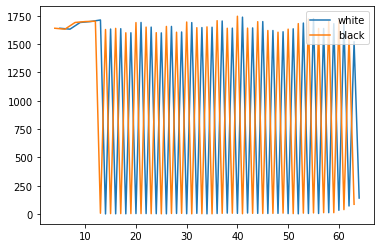

all: 100000 white: 50000 black: 50000


In [ ]:
white_df = train_df[train_df["player"] == 1]
black_df = train_df[train_df["player"] == 2]
print(white_df.loc[:, "player":"value"].describe())
print(black_df.loc[:, "player":"value"].describe())
fig, ax = plt.subplots(1,1)
wd = white_df["stones"].value_counts().sort_index()
bd = black_df["stones"].value_counts().sort_index()
ax.plot(wd, label = "white")
ax.plot(bd, label = "black")
ax.legend(loc = "upper right")
plt.show()
print(f"all: {len(train_df)} white: {len(white_df)} black: {len(black_df)}")

#making value net same as SLpn except of fc1

In [ ]:
class ValueNet_conv4(nn.Module):
  def __init__(self):
    super(ValueNet_conv4, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(64*8*8, 1)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

#making transform to rotate state

In [ ]:
def transform(state, mode = "None"):
    k = random.randint(0, 3)
    if mode == "train":
        p = k % 2
        if p > 0:
            state = np.flip(state, axis=1).copy()
        state = np.rot90(state, k, axes=(1, 2)).copy()

    elif mode == "valid":
        pass

    elif mode == "debug":
        k = 3 #0-3 existable pattern
        p = k % 2
        if p > 0:
            state = np.flip(state, axis=1).copy()
        state = np.rot90(state, k, axes=(1, 2)).copy()

    else:
        pass
        
    return state

#making dataset

In [ ]:
class ValueDatasets(Dataset):
    def __init__(self, df, mode="train"):
        self.state = df.loc[:, "state0":"state63"].values
        self.player = df.loc[:, "player"].values
        self.value = df.loc[:, "value"].values
        self.mode = mode

    def __len__(self):
        return len(self.player)
    
    def __getitem__(self, idx):
        state = transform_state(self.state[idx], self.player[idx])#or always black
        state = transform(state, mode=self.mode)
        state = torch.tensor(state).float()
        value = self.value[idx]
        value = torch.tensor([value]).float()
        return state, value

#making and checking splitter

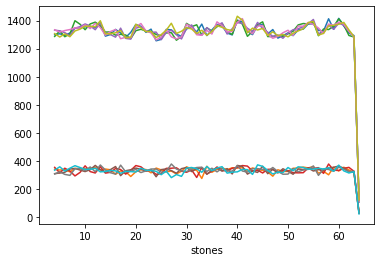

In [ ]:
n_FOLD = 5
KF = KFold(n_splits=n_FOLD, shuffle=True)
splitter = KF.split(train_df.state0, train_df.winner)
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("stones")
for train, test in splitter:
    pt = train_df.loc[train, "stones"].value_counts().sort_index()
    tpt = train_df.loc[test, "stones"].value_counts().sort_index()
    pt.plot()
    tpt.plot()
plt.show()

#making trainer

In [ ]:
def trainer(train_loader, valid_loader, model, criterion, optimizer):
    
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    model.train()
    for states, values in tqdm(train_loader):
      states = states.to(device)
      values = values.to(device)
      
      optimizer.zero_grad()
      outputs = model(states)

      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item() / len(train_loader)
      
      acc = mean_squared_error(values.cpu().detach().numpy(),
                          outputs.cpu().detach().numpy()) 
      train_acc += acc / len(train_loader)
        
    model.eval()
    with torch.no_grad():
      for states, values in tqdm(valid_loader):
        states = states.to(device)
        values = values.to(device)
        
        outputs = model(states)
        loss = criterion(outputs, values)
        
        val_loss += loss.item() / len(valid_loader)
        
        acc = mean_squared_error(values.cpu().detach().numpy(),
                             outputs.cpu().detach().numpy())
        val_acc += acc / len(valid_loader)
            
    return train_loss, train_acc, val_loss, val_acc

#value net train

In [ ]:
value_model = ValueNet_conv4().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(value_model.parameters(), lr)

In [ ]:
if TRAIN:
    spr = KF.split(train_df.loc[:, "state0":"state63"], train_df["value"])
    train_index, valid_index = next(spr)

    df_train = train_df.iloc[train_index]
    df_valid = train_df.iloc[valid_index]

    train_dataset = ValueDatasets(df_train, "train")
    valid_dataset = ValueDatasets(df_valid, "valid")
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

    train_loss_data, train_acc_data = [], []
    valid_loss_data, valid_acc_data = [], [] 

    for epoch in range(TRAIN_EPOCH):
        train_loss, train_acc, valid_loss, valid_acc = trainer(train_loader, valid_loader, value_model, criterion, optimizer)
        train_loss_data.append(train_loss)
        train_acc_data.append(train_acc)
        valid_loss_data.append(valid_loss)
        valid_acc_data.append(valid_acc)
        torch.save(value_model.state_dict(), VALUE_PARAM_PATH)
        print(f'Epoch [{epoch+1}/{TRAIN_EPOCH}] train (loss:{train_loss:.4f} acc:{train_acc:.4f}) valid (loss:{valid_loss:.4f} acc:{valid_acc:.4f})')

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/20] train (loss:0.8927 acc:0.8927) valid (loss:0.8619 acc:0.8619)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/20] train (loss:0.8382 acc:0.8382) valid (loss:0.8467 acc:0.8467)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/20] train (loss:0.8246 acc:0.8246) valid (loss:0.8266 acc:0.8266)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/20] train (loss:0.8132 acc:0.8132) valid (loss:0.8197 acc:0.8197)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/20] train (loss:0.8095 acc:0.8095) valid (loss:0.8184 acc:0.8184)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/20] train (loss:0.8042 acc:0.8042) valid (loss:0.8137 acc:0.8137)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/20] train (loss:0.8013 acc:0.8013) valid (loss:0.8137 acc:0.8137)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/20] train (loss:0.7962 acc:0.7962) valid (loss:0.8266 acc:0.8266)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/20] train (loss:0.7931 acc:0.7931) valid (loss:0.8097 acc:0.8097)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/20] train (loss:0.7897 acc:0.7897) valid (loss:0.8082 acc:0.8082)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/20] train (loss:0.7883 acc:0.7883) valid (loss:0.8128 acc:0.8128)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/20] train (loss:0.7851 acc:0.7851) valid (loss:0.8090 acc:0.8090)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/20] train (loss:0.7803 acc:0.7803) valid (loss:0.8073 acc:0.8073)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/20] train (loss:0.7775 acc:0.7775) valid (loss:0.8123 acc:0.8123)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/20] train (loss:0.7758 acc:0.7758) valid (loss:0.8083 acc:0.8083)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/20] train (loss:0.7759 acc:0.7759) valid (loss:0.8084 acc:0.8084)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/20] train (loss:0.7744 acc:0.7744) valid (loss:0.8088 acc:0.8088)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/20] train (loss:0.7694 acc:0.7694) valid (loss:0.8121 acc:0.8121)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/20] train (loss:0.7661 acc:0.7661) valid (loss:0.8299 acc:0.8299)


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/20] train (loss:0.7650 acc:0.7650) valid (loss:0.8192 acc:0.8192)


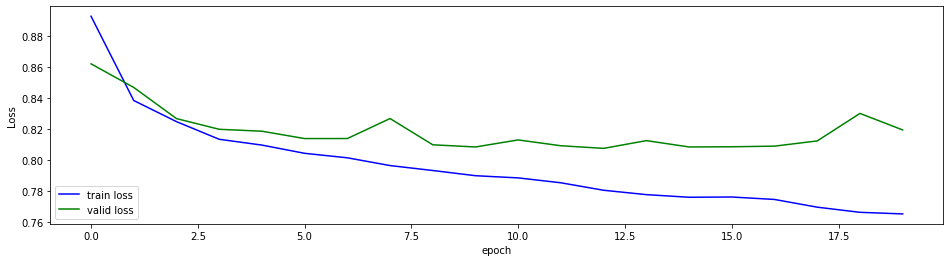

In [ ]:
if TRAIN:
    fig, ax = plt.subplots(1, 1, figsize=(16,4))
    ax.set_xlabel("epoch")
    ax.set_ylabel("Loss")
    ax.plot(train_loss_data, "b-", label="train loss")
    ax.plot(valid_loss_data, "g-", label="valid loss")
    ax.legend(loc = "lower left")

    #ax1 = ax.twinx()
    #ax1.set_ylabel("accuracy")
    #ax1.plot(train_acc_data, "r-", label="train acc")
    #ax1.plot(valid_acc_data, "m-", label="valid acc")
    #ax1.legend(loc = "upper right")

    plt.show()

#viewing value pred

In [ ]:
value_model.load_state_dict(torch.load(VALUE_PARAM_PATH))

<All keys matched successfully>

In [ ]:
test_df = train_df.sample(10)
print(test_df.loc[:, "state63":])
test_df = test_df.reset_index(drop = True)

       state63  player  winner  stones  value
92956        0       1       2      25     -1
79340        0       1       2      45     -1
65541        2       2       2      40      1
53609        0       2       1      24     -1
54994        2       1       1      57      1
22651        2       2       2      38      1
38138        1       1       1      51      1
37047        0       2       1      10     -1
30343        1       2       1      62     -1
1081         0       2       2      40      1


In [ ]:
#white, black = 1, 2
color = ("white", "black")
def policy_heatmap(state, pred, posts, player): 
  fig, ax= plt.subplots(1, 1, figsize=(6, 6))
  pred = pred.reshape(8, 8)
  #sns.heatmap(pred, square = True, ax = ax)
  plt.imshow(pred, interpolation='nearest', cmap='magma')
  plt.colorbar()

  for y in range(8):
    for x in range(8):
      st = state[y][x]

      if x + 8*y in posts:
          r = pat.Rectangle(xy=(x-0.38, y-0.38), width=0.8, height=0.8, linewidth=2, ec='g', fill=False)
          ax.add_artist(r)

      if st > 0:
        if st == 1:
          fc, ec = 'w', 'k' #face=white, edge=black
        elif st == 2:
          fc, ec = 'k', 'w'
        c = pat.Circle(xy=(x, y), radius=0.4, fc=fc, ec=ec, fill = True)
        ax.add_artist(c)

  pred_num = np.argsort(-pred.reshape(64))
  for y in range(8):
    for x in range(8):
      px = pred_num[x + y*8] % 8
      py = pred_num[x + y*8] // 8
      ax.text(px-0.25, py+0.25, f"{x + y*8 + 1}", size=10, color='green', fontweight='bold')
  if player == white:
    title = "player: white"
  else:
    title = "player: black"
  ax.set_title(title)
  plt.show()

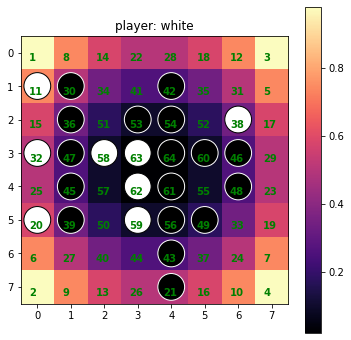

pred: 0.1651 reward: -1.0


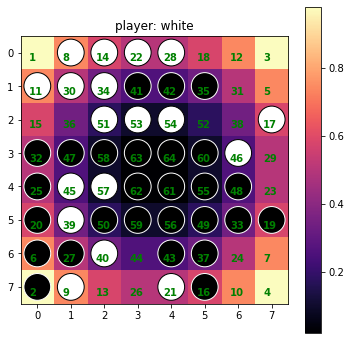

pred: -0.9356 reward: -1.0


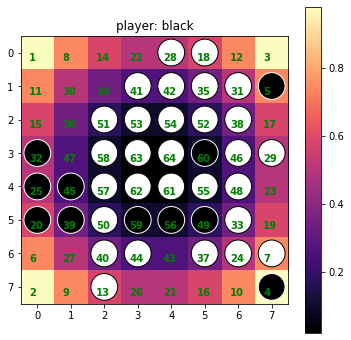

pred: 0.4866 reward: 1.0


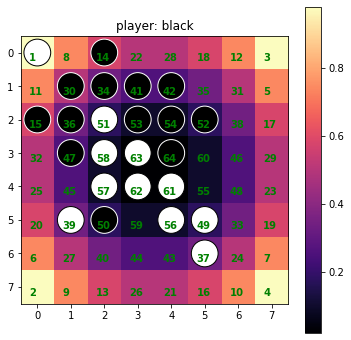

pred: -0.9244 reward: -1.0


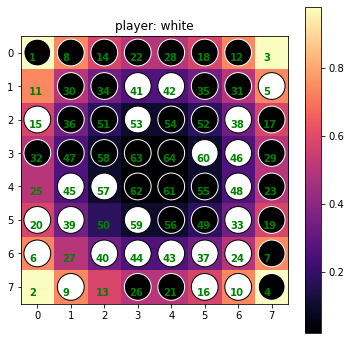

pred: -0.6670 reward: 1.0


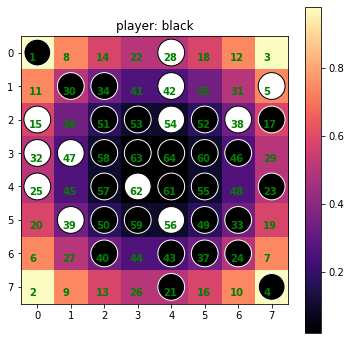

pred: 0.2161 reward: 1.0


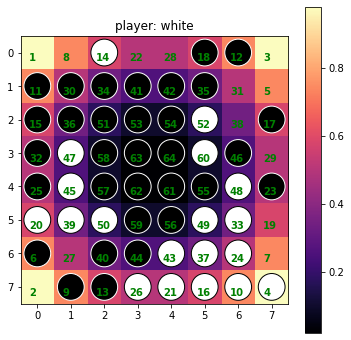

pred: 0.8154 reward: 1.0


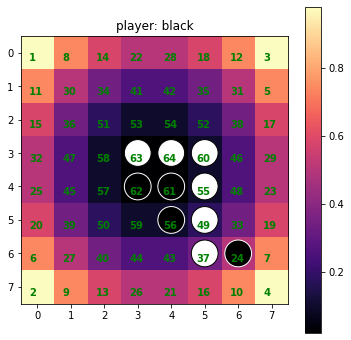

pred: -0.2519 reward: -1.0


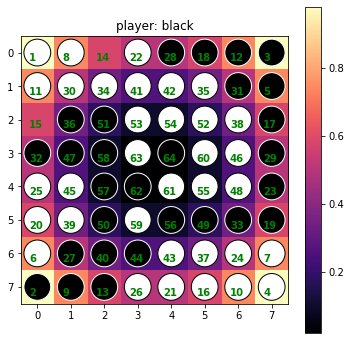

pred: -0.5352 reward: -1.0


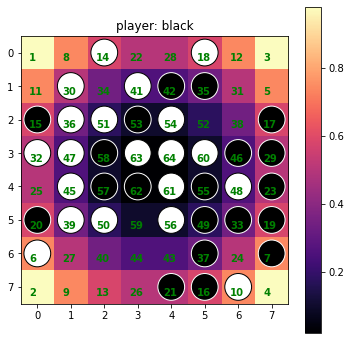

pred: 0.4354 reward: 1.0


In [ ]:
org_state = test_df.loc[:, "state0":"state63"].values
org_state = org_state.reshape(-1, 8, 8)
test_dataset = ValueDatasets(test_df, "valid")
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

_array = [[0]*8 for _ in range(8) ]
for y in range(8):
    for x in range(8):
        _array[y][x] = 0.04 * (x - 3.5)**2 + 0.04 * (y - 3.5)**2

array = np.array(_array)

for i, (test_state, value_y) in enumerate(test_loader):
    test_state = test_state.to(device)
    pred = value_model(test_state)
    #array = np.random.rand(8,8)
    policy_heatmap(org_state[i], array, [], test_df.loc[i, "player"])
    print(f"pred: {pred.item():.4f} reward: {value_y.item():.1f}")